# FFT

## setup
generic start to notebook

In [21]:
## header for our functions
# load our code
import sys
import os
from matplotlib import pyplot as plt
sys.path.insert(0, os.path.abspath('../'))
# specific to jupyter notebook
from jupyter_help import cvplt, cvplt_sub, VidHelp, mkgray
#Import image processing function from optimization
# load any changes as we make them
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read in an some frames from an example video

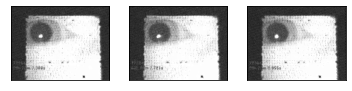

In [256]:
vid_fname = "../input/run1.mov"
vs = VidHelp(vid_fname)
frames = vs.get_frames(range(200,241))
plt.gray()
cvplt_sub([frames[:,:,0], frames[:,:,20],frames[:,:,40]])


## fft+ifft - there and back
just to confirm we have the math/procedure correct.

The transform is not lossless: the difference between original and transformed+inverse is non zero.

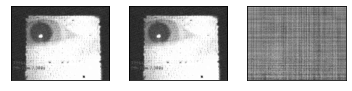

In [164]:
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift
# confirm we can reconsturct
frame0 = frames[:,:,0]
spec_orig =fft2(frame0);
spec_img = fftshift(spec_orig);
frame0_ifft =  ifft2(ifftshift(spec_img))

plt.gray()
cvplt_sub([frame0, frame0_ifft.real, frame0 - frame0_ifft.real])

## Magnitude

from [dsp.so:rm periodic noise](https://dsp.stackexchange.com/questions/20061/removing-periodic-noise-from-image-using-fourier-transform)

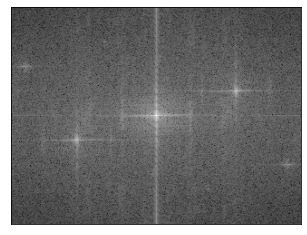

In [165]:
mag_spec = 20*np.log(np.abs(spec_img))
cvplt(mag_spec)

let's look at just the top of the image that should be black

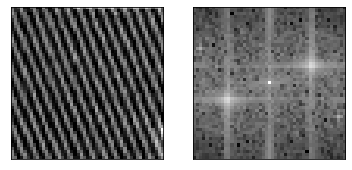

In [166]:
topbox = frames[1:50,0:49,0]
mag_box = 20*np.log(np.abs(fftshift(fft2(topbox))));

cvplt_sub([topbox,mag_box])

# Filtering

Can we do anything about it?  [so:rm preodic noise](https://stackoverflow.com/questions/34027840/removing-periodic-noise-from-an-image-using-the-fourier-transform)

In [203]:
def mask_point(cnt, censor_size, shape=[9999,9999]):
    rm_x = slice(max(0, cnt[0] -censor_size), min(cnt[0] + censor_size, shape[0]))
    rm_y = slice(max(0, cnt[1] -censor_size), min(cnt[1] + censor_size, shape[1]))
    
    mask_pnt = np.zeros(shape, dtype=bool)
    mask_pnt[rm_x, rm_y] = True
    return mask_pnt

def fft_censor(orig, censor_mask):
    spec_orig = fft2(orig)
    spec_img = fftshift(spec_orig)
    if censor_mask is not None:
        spec_img[censor_mask] = 0
    return ifft2(ifftshift(spec_img)) 


## Find centers
using kmeans


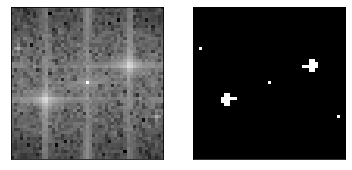

In [65]:
import sklearn.cluster as clust
high_thres = (np.mean(mag_box)+np.std(mag_box)*2.5)
mag_box_mask = mag_box > high_thres
cvplt_sub([mag_box,mag_box_mask])

[[19 37]
 [29 11]
 [35 46]
 [24 24]
 [13  2]]


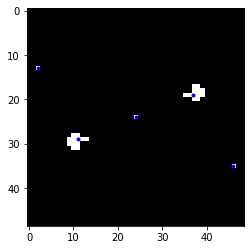

In [205]:
mag_coords = np.argwhere(mag_box_mask)
pts = clust.KMeans(n_clusters=5).fit(mag_coords)
# this is weird. imshow puts 0 on top. adjust coords
boxmag_centers = np.round(pts.cluster_centers_).astype('int')
plt.imshow(mag_box_mask)
plt.plot(boxmag_centers[:,1], boxmag_centers[:,0],'b.')
print(boxmag_centers)

## permutations

Looking at each point individually.

something is off (with code/math)

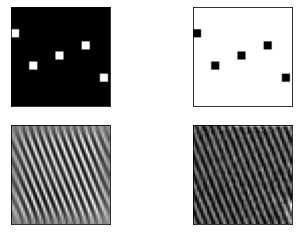

In [206]:
censor_size = 2
# combine all the centers into one mask with as squares
# also get the opposite mask (only where centers are not)
# ideally we can show what just the centers would generate
# and what their abscence shows
cmasks3D = np.stack([mask_point(cnt, censor_size, topbox.shape) for cnt in boxmag_centers], axis=2)
mask_all = np.sum(cmasks3D,axis=2) >= 1
anti_mask = np.logical_not(mask_all)

fft_masked = fft_censor(topbox, mask_pnt).real
fft_anti_masked = fft_censor(topbox, anti_mask).real

cvplt_sub([mask_all, anti_mask,
           fft_anti_masked,fft_masked], 2,2)


The difference between the censored fft and original shows some strange pattern. where as the difference between the original and the nonmasked fft+ifft looks like static (?)

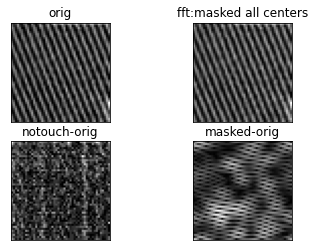

In [194]:
notouch_ifft = fft_censor(topbox,None).real
cvplt_sub({'orig':topbox, 
           'fft:masked all centers': fft_masked, 
           'notouch-orig': abs(notouch_ifft-topbox),
           'masked-orig': abs(fft_masked - topbox)},
          2,2)

looking at each individually is maybe not so useful

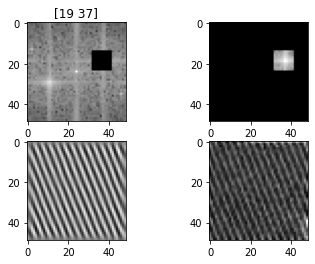

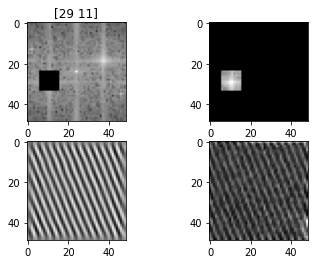

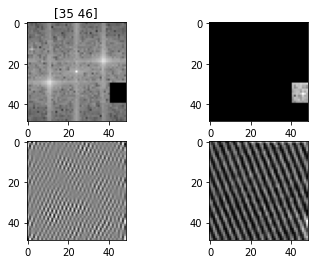

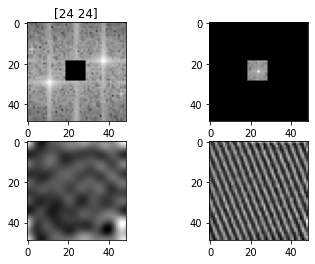

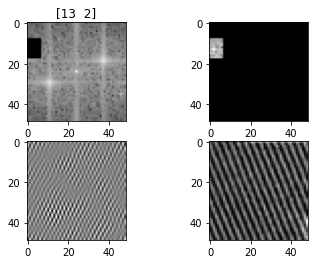

In [207]:
censor_size = 5
rmrng = np.arange(-s, s+1)
for cnt in boxmag_centers:
    mask_pnt = mask_point(cnt, censor_size, topbox.shape)
    
    rm = mag_box.copy()
    rm[mask_pnt] = 0
    
    only = np.zeros(mag_box.shape)
    only[mask_pnt] = mag_box[mask_pnt]
        
    plt.subplot(2,2,1)    
    plt.imshow(rm)
    plt.title(f'{cnt}')
    
    plt.subplot(2,2,2)
    plt.imshow(only)
    
    plt.subplot(2,2,3)
    all_but_mask = np.logical_not(mask_pnt)
    plt.imshow(fft_censor(topbox, all_but_mask).real)
    
    plt.subplot(2,2,4)
    plt.imshow(fft_censor(topbox, mask_pnt).real)
    plt.show()

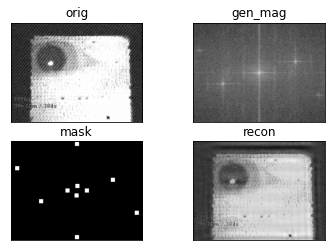

In [227]:
def gen_mag(frame):
    mag = 20*np.log(np.abs(fftshift(fft2(frame))))
    return mag
    
def mag_centers(frame, n_clusters=5):
    mag = gen_mag(frame)
    high_thres = (np.mean(mag)+np.std(mag)*2.5)
    mask = mag > high_thres
 
    coords = np.argwhere(mask)
    kmfit = clust.KMeans(n_clusters=n_clusters).fit(coords)
    kmcenters = np.round(kmfit.cluster_centers_).astype('int')
    return kmcenters

def gen_mask(kmcenters, shape, censor_size=2):
    all_masks = [mask_point(cnt, censor_size, shape) for cnt in kmcenters]
    cmasks3D = np.stack(all_masks, axis=2)
    mask_all = np.sum(cmasks3D,axis=2) >= 1
    return mask_all

f0_coords = mag_centers(frame0, 10)
f0fft_mask = gen_mask(f0_coords, frame0.shape, 5)
recon = fft_censor(frame0, f0fft_mask).real
cvplt_sub({'orig':frame0, 'gen_mag':gen_mag(frame0), 
           'mask': f0fft_mask,'recon': recon},2,2)


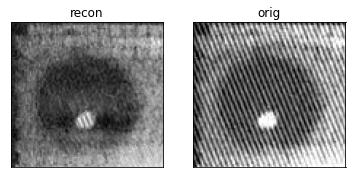

In [243]:
cvplt_sub({'recon': recon[30:130,45:150], 'orig': frame0[30:130,45:150]})

In [275]:
fft_eye = [fft_censor(frames[:,:,i], f0fft_mask).real[30:130,45:150] for i in range(10)]
eye_mat = np.stack(fft_eye,axis=2)

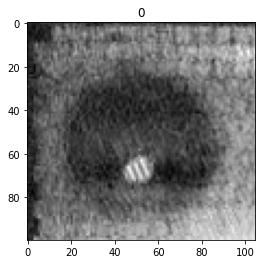

In [277]:
from jupyter_help import animate_matrix
from matplotlib import rc
rc('animation',html='html5')
animate_matrix(eye_mat)

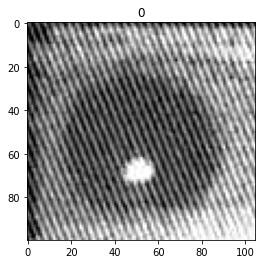

In [283]:
orig_eye10 = frames[30:130,45:150,1:10]
animate_matrix(orig_eye10)